# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 49

**Author 1 (sciper):** Mariane Brodier (250488)  
**Author 2 (sciper):** Lucas Bost (270139)   
**Author 3 (sciper):** Nicolas Delamaide (271789)   

**Release date:** 12.03.2021  
**Due date:** 26.03.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* Additional method of your choice (5 pts)

Each section should display the resulting segmenttion as well as the size in pixel of the detected region. Comment each method limitations and/or advantages.

### 1.1 Brain image visualization

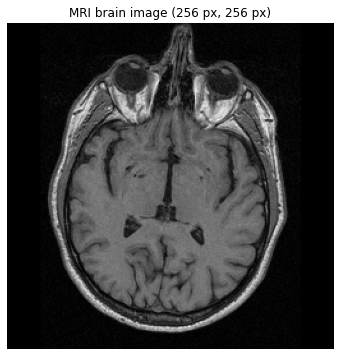

In [2]:
import skimage.io
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing (5pts)

#### Histogram

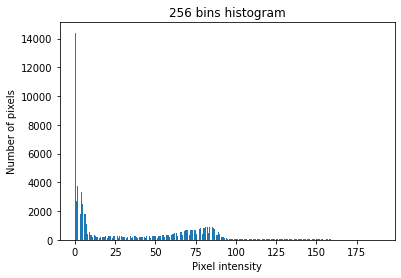

In [3]:
nb_bins = 256

# Display histogram
plt.figure(figsize=(6, 4))
plt.hist(brain_im.ravel(), bins=nb_bins)
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.title(f"{nb_bins} bins histogram")

plt.show()

#### Region growing algorithm

In [4]:
# Finds the 8 neighbors of point and the value of the pixels of those neighbors in image
def neighbors(point, image):
    
    valid = []
    values = [] # To store values of neighboring pixels
    
    height, width = image.shape
    # x and y are inverted
    y = point[1]
    x = point[0]
    
    # Starting point out of bounds
    if (y >= height) | (x >= width) | (y < 0) | (x <0):
        return valid, values
    
    # Left
    if y-1 >= 0: # indexing starts at 0
        valid.append((x, y-1))
        values.append(image[x, y-1])
        
        # Top left
        if x-1 >= 0:
            valid.append((x-1, y-1))
            values.append(image[x-1, y-1])
        # Bottom left
        if x+1 < width:
            valid.append((x+1, y-1))
            values.append(image[x+1, y-1])
        
    # Right
    if y+1 < height:
        valid.append((x, y+1))
        values.append(image[x, y+1])
        
         # Top right
        if x-1 >= 0:
            valid.append((x-1, y+1))
            values.append(image[x-1, y+1])
        # Bottom right
        if x+1 < width:
            valid.append((x+1, y+1))
            values.append(image[x+1, y+1])
    # Top
    if x-1 >= 0:
        valid.append((x-1, y))
        values.append(image[x-1, y])
        
    # Bottom
    if x+1 < width:
        valid.append((x+1, y))
        values.append(image[x+1, y])
    
    return valid, values

In [5]:
# Region growing on image starting at the seed
# The criterion is a threshold criterion on the standard deviation of the neighboring region
# of a pixel
def regionGrowing(image, criterion, seed):
    height, width = image.shape
    
    visited = np.zeros((height,width))
    region = np.copy(image)
    region[:, :] = 0 # Black image
    
    region[seed[0], seed[1]] = 255
    visited[seed[0], seed[1]] = 1
    
    to_visit = [] # queue 
    to_visit.append(seed) # add seed to queue
    
    while to_visit: # while there is a point to visit
        
        target = to_visit.pop() # Take first element in queue
        
        # Neighbors
        next_to, values = neighbors(target, image)
        
        # Check if local variance lower than threshold
        if (np.std(values) < criterion):
            region[target[0], target[1]] = 255#image[target[0], target[1]] # White pixel

            for point in next_to:
            
                # Check if point has been visited
                if ((visited[point[0], point[1]]!=1)):
                    visited[point[0], point[1]] = 1
                    to_visit.append(point)
        else: 
            for point in next_to:
                visited[point[0], point[1]] = 1
                
    return region

In [6]:
seed = (150, 150)
region = regionGrowing(brain_im, 9.8, seed) # Criterion was selected iteratively

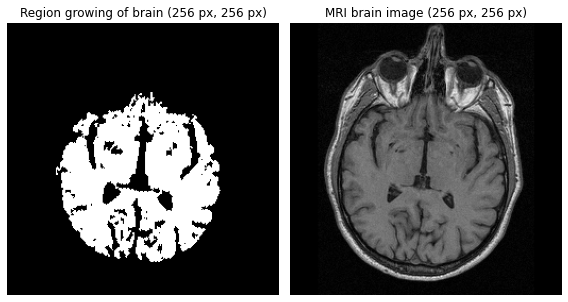

In [7]:
# Display images
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(region, cmap="gray")
ax[0].set_title('Region growing of brain ({} px, {} px)'.format(im_h, im_w))
ax[0].axis('off')

ax[1].imshow(brain_im, cmap="gray")
ax[1].set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax[1].axis('off')

plt.tight_layout()
plt.show()

#### Results

In [8]:
size = len(region[region[:,:]==255])
print(f"The size of the brain in number of pixels is : {size}")

The size of the brain in number of pixels is : 14355


**Comments :** <br>
Region growing is a simple method to define a region and pretty straightforward. However, it is highly dependent on the seed and on the criterion used to find a correct solution to the problem. Here we used prior knowledge about the MRI image to define the seed, i.e somewhere in the gray area in the middle of what we know is the skull. Furthermore, since we know the brain is an homogeneous texture we used a criterion based on the local variance of the intensity of the pixels. We also can see on the right image above that there is a dark area between the brain (in gray) and the skull (in white), thus there is a high local variance of the pixels at the border of the brain, making this criterion suitable for the problem.

### 1.3 Contour detection (5pts)

To define a region, one can search for sharp edges with contour-based methods. Here we used the zero-crossing of the second derivative method, using the Laplacian of Gaussian.

We first filtered the image to remove the noise and undesired details with a Gaussian filter, then we computed the second derivative of the filtered image using the Laplacian filter.

To find edges on an image, one can compute the zero-crossing points of the second derivative values of the filtered image. In order to do that, we implemented the zero-crossing algorithm.

Our algorithm goes through all the image pixels. At each pixel, it takes its neighbour pixels (8-connected pixels) and define which pixels represent the minimum and maximum values of the neighbourhood. Then it computes the difference between those two values : it should be bigger than a certain threshold, otherwise the pixel won't be considered as an edge. It also computes how many positive and negative values are present in the neighbourhood : there must be positive and negative values in the neighbourhood for the pixel to be considered as a zero-crossing point. If a pixel is considered as an edge and a zero-crossing point, it will appear in white in the resulted image.

We then use the closing operator to fill the skull contour holes, and finally we set the pixel of the brain at 255 by placing a seed and using the flood fill algorithm in order to only get an image of the brain pixels.

We computed the number of pixels defining the brain and we get 15013 pixels.

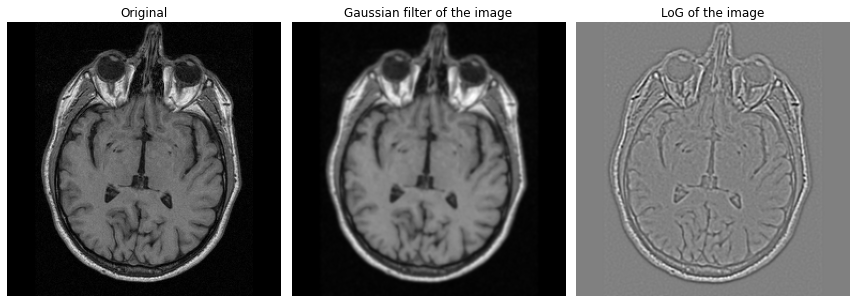

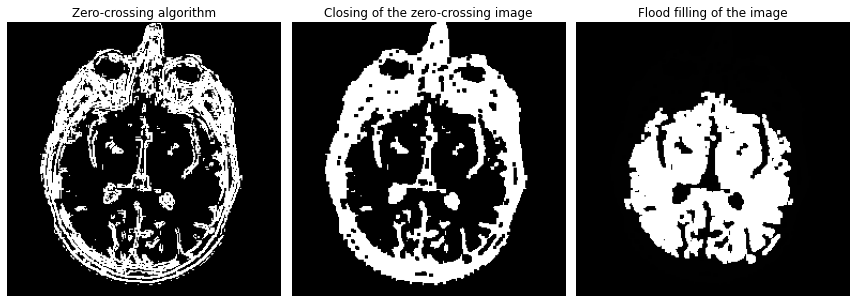

Number of pixels :  15013


In [9]:
from skimage import filters, measure, morphology, segmentation

# Filter the image to remove the noise and undesired details with a Gaussian filter
gaussian = filters.gaussian(brain_im, sigma=1)

# Convolve the image by the second derivative of a Gaussian « Laplacian of Gaussian »
log = filters.laplace(gaussian)

# Display the result
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

ax[0].imshow(brain_im, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(gaussian, cmap='gray')
ax[1].set_title('Gaussian filter of the image')
ax[1].axis('off')

ax[2].imshow(log, cmap='gray')
ax[2].set_title('LoG of the image')
ax[2].axis('off')

plt.tight_layout()
plt.show()

# Zero-crossing parameters
thres = 0.05
zc_img = np.zeros(log.shape)
w = zc_img.shape[1]
h = zc_img.shape[0]

# Zero-crossing algorithm
for x in range(1, h-1):
    for y in range(1, w-1):
        minVal = 0
        maxVal = 0
        neg = 0
        pos = 0
        # Go through the neighbourhood of each pixel
        for i in range(-1, 2, 1):
            for j in range(-1, 2, 1):
                # Define minVal
                if(log[x+i, y+j] < minVal):
                    minVal = log[x+i, y+j]
                # Define maxVal
                if(log[x+i, y+j] > maxVal):
                    maxVal = log[x+i, y+j]
                # Computing how many negative and positive values there are in the neighbourhood
                if(log[x+i, y+j] < 0):
                    neg += 1  
                if(log[x+i, y+j] > 0):
                    pos += 1
        delta = maxVal - minVal
        # If delta < thres : not an edge
        # If neg = 0 or pos = 0 : not a zero crossing
        zero_cross = ((delta > thres) and (neg > 0) and (pos > 0))
        if(zero_cross):
            zc_img[x,y] = 1

# Closing the zero-crossing image to see better the brain
closed_img = morphology.closing(zc_img, morphology.square(3))

# Setting the brain pixels at 255 by placing a seed at coordinates (100,100)
output = segmentation.flood_fill(closed_img, (100,100), 255)

# Display the result
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

ax[0].imshow(zc_img, cmap='gray')
ax[0].set_title('Zero-crossing algorithm')
ax[0].axis('off')

ax[1].imshow(closed_img, cmap='gray')
ax[1].set_title('Closing of the zero-crossing image')
ax[1].axis('off')

ax[2].imshow(output, cmap='gray')
ax[2].set_title('Flood filling of the image')
ax[2].axis('off')

plt.tight_layout()
plt.show()


# Computing the pixel numbers defining the brain
pixels = int(output[output==255].sum()/255)
print('Number of pixels : ', pixels)

### 1.4 Additional method (5pts)

We will try the method of morphological snakes similar to active contours. It is based on https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_morphsnakes.html#sphx-glr-auto-examples-segmentation-plot-morphsnakes-py

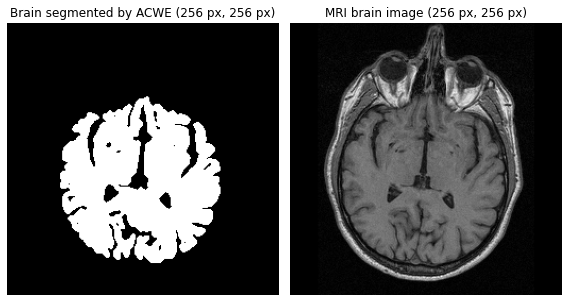

In [10]:
from skimage.segmentation import morphological_chan_vese, disk_level_set

# Initial level set
init_ls = disk_level_set(brain_im.shape ,center = (175,125), radius = 25)

ls = morphological_chan_vese(brain_im, 250, init_level_set=init_ls, smoothing=1,
                             lambda1 = 80, lambda2 = 20)


# Display images
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(ls, cmap="gray")
ax[0].set_title('Brain segmented by ACWE ({} px, {} px)'.format(im_h, im_w))
ax[0].axis('off')

ax[1].imshow(brain_im, cmap="gray")
ax[1].set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax[1].axis('off')

plt.tight_layout()
plt.show()

#### Results

In [11]:
size = len(ls[ls[:,:]!=0])
print(f"The size of the brain in number of pixels is : {size}")

The size of the brain in number of pixels is : 15667


#### Comments

We used the Morphological Active Contours without Edges method (MorphACWE) because it is well suited for the MRI image we have. The contours of the brain are not well defined and it works on an image without pre processing, which according to the documentation is when we should use this method. Overall this method is good and easy to use and only requires tuning the smoothing parameter as well as lambda1 and lambda2, which correspond to the weight parameter of the outer and inner region respectively.

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

### 2.1 Visualization

In [12]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


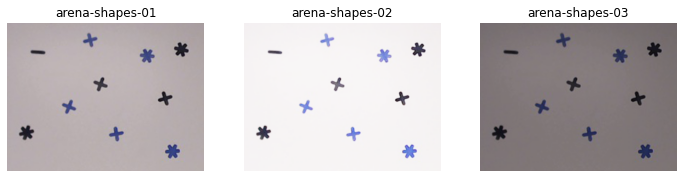

In [13]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

In [14]:
import cv2 as cv
from skimage.filters import threshold_multiotsu

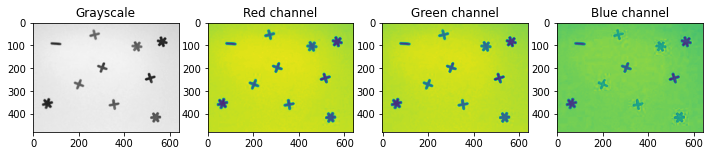

In [15]:
gray = skimage.color.rgb2gray(images[0])
red = images[0,...,0]
green = images[0,...,1]
blue = images[0,...,2]
fig, axes = plt.subplots(1, 4, figsize=(12, 12))
axes[0].imshow(gray, cmap = 'gray')
axes[0].set_title('Grayscale')
axes[1].imshow(red)
axes[1].set_title('Red channel')
axes[2].imshow(green)
axes[2].set_title('Green channel')
axes[3].imshow(blue)
axes[3].set_title('Blue channel')
plt.show()

In order to count the shapes of each color, we wanted to separates the colors in differents images. At first we tried to do that with the grayscale image but the difference between black and blue wasn't significant enough. So we separate the color channels of the image and we found that the blue channel allows to differenciate better the black and the blue.

In [16]:
def extract_blkshp(img):
    """ Function that creates an image with only the black shapes (pixel value of 0) and background (pixel value of 255)"""
    
    #Get an image with only black pixels
    Blackpxls = img == 0
    
    #Extract the black shapes
    closing = morphology.binary_closing(Blackpxls)
    erosion = morphology.binary_erosion(closing)
    dilation1 = morphology.binary_dilation(erosion)
    dilation2 = morphology.binary_dilation(dilation1)
    
    #Convert the image into an image with values 0 and 255
    temp = dilation2.astype('uint8')
    output = 255 * temp
    
    return output

In [17]:
def extract_blushp(img):
    """ Function that creates an image with only the blue shapes (pixel value of 0) and background (pixel value of 255)"""
    
    #Get an image with only blue pixels
    Bluepxls = img == 1
    
    #Extract the blue shapes
    closing1 = morphology.area_closing(Bluepxls)
    dilation1 = morphology.binary_dilation(closing1)
    closing2 = morphology.area_closing(dilation1)
    erosion1 = morphology.binary_erosion(closing2)
    erosion2 = morphology.binary_erosion(erosion1)
    erosion3 = morphology.binary_erosion(erosion2)
    dilation2 = morphology.binary_dilation(erosion3)
    dilation3 = morphology.binary_dilation(dilation2)
    dilation4 = morphology.binary_dilation(dilation3)
    opening = morphology.area_opening(dilation4)
    closing3 = morphology.binary_closing(opening)
    
    #Convert the image into an image with values 0 and 255
    temp = closing3.astype('uint8')
    output = 255 * temp
    
    return output

In [18]:
def count_shapes(img):
    """Function that count the number of black shapes and blue shapes in an image"""
    
    #Performs intensity normalization on the blue channel of the input image to avoid effects from illumination
    norm_im = skimage.exposure.rescale_intensity(img[...,2])
    
    #Use multi otsu method to separates the blue pixels, the black pixels and the background in only 3 different values
    #0 for black, 1 for blue and 2 for background
    threshold = threshold_multiotsu(norm_im)
    digitized_im = np.digitize(norm_im, bins=threshold)
    
    #Extract the blue shapes and the black shapes
    black_shapes = extract_blkshp(digitized_im)
    blue_shapes = extract_blushp(digitized_im)
    
    #Apply edge detection
    black_edges = cv.Canny(black_shapes, 100, 200)
    blue_edges = cv.Canny(blue_shapes, 100, 200)
    
    #Find the countours 
    black_contours, black_hierarchy = cv.findContours(black_edges.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    blue_contours, blue_hierarchy = cv.findContours(blue_edges.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE) 
    
    #Find the number of shapes in each image
    nb_black = len(black_contours)
    nb_blue = len(blue_contours)
    
    return black_shapes, blue_shapes, nb_black, nb_blue

The first thing we had to do was to normalize the illumination of the image to be robust to any kind of illumination (strong, normal, weak). In order to do that we used the function rescale_intensity() of the module exposure which performs a normalization of intensity by adpting the image to have a minimum value of 0 and a maximum value of 255. To separate the colors we used the multi otsu thresholding method. This allows to separate the pixels of an image in different classes, in our case 3 classes: black, blue and background. We digitized the image using the thresholds found which created an image with values of 0 for black pixels, values of 1 for blue pixels and values of 2 for background. Then we created images with only black shapes or blue shapes by testing the values of pixels. But it wasn't enough and we had to apply some morphological operators to have a better result. For the black shapes it was easier because the black shapes were quite well defined in the digitized image. For the blue shapes it was more difficult since parts of the middle of the shapes were mistaken with the background. But finally we managed to create function to extract black shapes and blue shapes. We performed an edge detection on both resulting images using the function Canny() of opencv. This created images with only the contours of the shapes. We used the function findContours() of opencv to find the contours coordinates and using function len() we were able to count the number of contours and therefore the number of shapes in each image.

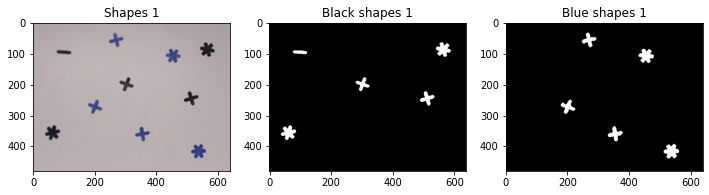

The number of black shapes in the image is 5
The number of blue shapes in the image is 5


In [19]:
blk_1, blue_1, nb_blk_1, nb_blue_1 = count_shapes(images[0])
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
axes[0].imshow(images[0])
axes[0].set_title('Shapes 1')
axes[1].imshow(blk_1, cmap = 'gray')
axes[1].set_title('Black shapes 1')
axes[2].imshow(blue_1, cmap = 'gray')
axes[2].set_title('Blue shapes 1')
plt.show()
print("The number of black shapes in the image is", nb_blk_1)
print("The number of blue shapes in the image is", nb_blue_1)

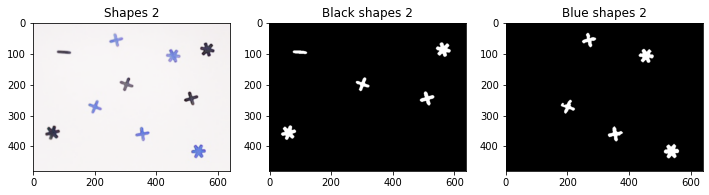

The number of black shapes in the image is 5
The number of blue shapes in the image is 5


In [20]:
blk_2, blue_2, nb_blk_2, nb_blue_2 = count_shapes(images[1])
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
axes[0].imshow(images[1])
axes[0].set_title('Shapes 2')
axes[1].imshow(blk_2, cmap = 'gray')
axes[1].set_title('Black shapes 2')
axes[2].imshow(blue_2, cmap = 'gray')
axes[2].set_title('Blue shapes 2')
plt.show()
print("The number of black shapes in the image is", nb_blk_2)
print("The number of blue shapes in the image is", nb_blue_2)

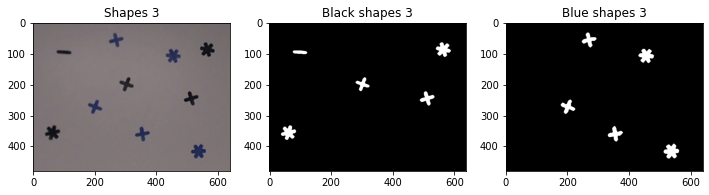

The number of black shapes in the image is 5
The number of blue shapes in the image is 5


In [21]:
blk_3, blue_3, nb_blk_3, nb_blue_3 = count_shapes(images[2])
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
axes[0].imshow(images[2])
axes[0].set_title('Shapes 3')
axes[1].imshow(blk_3, cmap = 'gray')
axes[1].set_title('Black shapes 3')
axes[2].imshow(blue_3, cmap = 'gray')
axes[2].set_title('Blue shapes 3')
plt.show()
print("The number of black shapes in the image is", nb_blk_3)
print("The number of blue shapes in the image is", nb_blue_3)

We see that our results are correct in any case of illumination. A potential improvement would have been to have a better digitized image with better defined blue shapes in order to make the extraction of blue shapes easier.

### 2.3 Total area (in pixels) of each color (5 pts)

In [22]:
def calculate_area(img):
    """Function that calculates the area covered by shapes in an image"""
   
    area = 0
    for m in range(img.shape[0]):
        for n in range(img.shape[1]):
            if img[m][n] == 255:
                area += 1
                
    return area

In [23]:
def shapes_area(img):
    """Function that returns the areas covered by black shapes and by blue shapes"""
    
     #Performs intensity normalization on the blue channel of the input image to avoid effects from illumination
    norm_im = skimage.exposure.rescale_intensity(img[...,2])
    
    #Use multi otsu method to separates the blue pixels, the black pixels and the background in only 3 different values
    #0 for black, 1 for blue and 2 for background
    threshold = threshold_multiotsu(norm_im)
    digitized_im = np.digitize(norm_im, bins=threshold)
    
    #Extract the blue shapes and the black shapes
    black_shapes = extract_blkshp(digitized_im)
    blue_shapes = extract_blushp(digitized_im)
    
    #Get the areas
    black_area = calculate_area(black_shapes)
    blue_area = calculate_area(blue_shapes)
    
    return black_area, blue_area

We used the same method that for part 2.1 to obtain images with only the black shapes or only the blue shapes, with values 0 for the background and 255 for the shapes. The we just used a function that counts the number of pixels with value 255 in the image to calculate the area.

In [24]:
blk_area_1, blue_area_1 = shapes_area(images[0])
print("The area covered by black shapes in image 1 is (in pixels)", blk_area_1)
print("The area covered by blue shapes in image 1 is (in pixels)", blue_area_1)
blk_area_2, blue_area_2 = shapes_area(images[1])
print("The area covered by black shapes in image 2 is (in pixels)", blk_area_2)
print("The area covered by blue shapes in image 2 is (in pixels)", blue_area_2)
blk_area_3, blue_area_3 = shapes_area(images[2])
print("The area covered by black shapes in image 3 is (in pixels)", blk_area_3)
print("The area covered by blue shapes in image 3 is (in pixels)", blue_area_3)

The area covered by black shapes in image 1 is (in pixels) 5007
The area covered by blue shapes in image 1 is (in pixels) 5949
The area covered by black shapes in image 2 is (in pixels) 4776
The area covered by blue shapes in image 2 is (in pixels) 5363
The area covered by black shapes in image 3 is (in pixels) 4984
The area covered by blue shapes in image 3 is (in pixels) 6037
